In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import re
from collections import Counter
from urllib.parse import urlparse
from sentence_transformers import SentenceTransformer
import numpy as np
import json
import xml.etree.ElementTree as ET
from huggingface_hub import InferenceClient
from typing import Dict, List
import os
from groq import Groq

/home/mettaleb/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-16 13:23:49.825043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750073030.388396 1138580 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750073030.563810 1138580 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-16 13:23:52.319328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operat

## Vérifier si une page contient des tables ou pas

In [19]:
def has_table(url,type_table):
    try:
        response = requests.get(url)
        response.raise_for_status()
        html_content = response.text
    
        soup = BeautifulSoup(html_content, 'html.parser')
        external_links_header = None
        for header in soup.find_all(['h2', 'h3', 'h4', 'h5', 'h6']):
            if header.get_text().strip().lower() in ['external links', 'liens externes', 'references']:
                external_links_header = header
                break
    
        if external_links_header:
            for sibling in external_links_header.find_all_next():
                sibling.decompose()
        tables_html = soup.find_all('table')
        for table in tables_html:
            if any(c in table.get('class', []) for c in ['ambox', 'metadata', 'box-Primary_sources', 'nowraplinks' ]):
                continue
            if table.get('role') == 'presentation':
                continue
            if type_table == "table":
                if 'infobox' not in table.get('class', []):
                    return True
            elif type_table == "infobox":
                if 'infobox' in table.get('class', []):
                    return True
                
        
        return False
    except:
        pass



In [16]:
with open("liens_wiki_all.txt") as f:
    urls = f.readlines()
Links = [url.strip() for url in urls]

In [ ]:
Tables_links = []
for link in Links:
    if has_table(link, "table"):
        Tables_links.append(link)

In [2]:
with open("links_wiki_with_tables.txt") as f:
    urls = f.readlines()
Tables_links = [url.strip() for url in urls]

In [3]:
len(Tables_links)

354

## Liens ves les pages Wikipédia

### 1. Tous liens ves les pages contenant tables

#### 1.1) Au moins table de type "table"

In [4]:
with open("links_wiki_with_tables.txt") as f:
    urls = f.readlines()
Tables_links = [url.strip() for url in urls]

In [5]:
len(set(Tables_links))

354

#### 1.2) Au moins table de type "infobox"

In [17]:
Infobox_links = []
for link in Links:
    if has_table(link, "infobox"):
        Infobox_links.append(link)

In [19]:
len(set(Infobox_links))

2742

### 2. Liens vers les pages que nous avons annotés

In [6]:
folder_path = "/projects/melodi/mettaleb/CORE/100_paragraphes_tables/tables/"
csv_files = [file.split(".")[0] for file in os.listdir(folder_path) if file.endswith('.csv')]
links = []
for file in csv_files :
    link = f"https://en.wikipedia.org/wiki/{file}"
    links.append(link)

In [7]:
len(links)

99

### Nouvelle liens (hors (2))

In [8]:
new_links = [link for link in Tables_links if link not in links]

In [9]:
len(set(new_links))

266

In [10]:
new_links = list(set(new_links))

# Extract Wikipedia Tables

In [10]:
def extract_wikipedia_tables(url):
    response = requests.get(url)
    response.raise_for_status()
    html_content = response.text

    soup = BeautifulSoup(html_content, 'html.parser')

    external_links_header = None
    for header in soup.find_all(['h2', 'h3', 'h4', 'h5', 'h6']):
        if header.get_text().strip().lower() in ['external links', 'liens externes', 'references']:
            external_links_header = header
            break

    if external_links_header:
        for sibling in external_links_header.find_all_next():
            sibling.decompose()

    tables_html = soup.find_all('table')
    infobox_tables_html = soup.find_all('table', class_='infobox')

    dataframes = []

    for table in infobox_tables_html:
        df_list = pd.read_html(str(table))
        if df_list:
            df = df_list[0]
            dataframes.append(('infobox', df))

    for table in tables_html:
        if any(c in table.get('class', []) for c in ['ambox', 'metadata', 'box-Primary_sources', 'nowraplinks' ]):
            continue
        if table.get('role') == 'presentation':
            continue
        if 'infobox' not in table.get('class', []):
            df_list = pd.read_html(str(table))
            if df_list:
                df = df_list[0]
                dataframes.append(('table', df))

    return dataframes

In [11]:


def extract_wikipedia_tables(url):
    response = requests.get(url)
    response.raise_for_status()
    html_content = response.text

    soup = BeautifulSoup(html_content, 'html.parser')

    external_links_header = None
    for header in soup.find_all(['h2', 'h3', 'h4', 'h5', 'h6']):
        if header.get_text().strip().lower() in ['external links', 'liens externes', 'references']:
            external_links_header = header
            break

    if external_links_header:
        for sibling in external_links_header.find_all_next():
            sibling.decompose()

    def find_nearest_header(tag):
        for prev in tag.find_all_previous():
            if prev.name in ['h2', 'h3', 'h4', 'h5', 'h6']:
                return prev.get_text(strip=True)
        return "No Section"

    tables_html = soup.find_all('table')
    infobox_tables_html = soup.find_all('table', class_='infobox')

    dataframes = []

    for table in infobox_tables_html:
        header = find_nearest_header(table)
        df_list = pd.read_html(str(table))
        if df_list:
            df = df_list[0]
            dataframes.append(('infobox', header, df))

    for table in tables_html:
        if any(c in table.get('class', []) for c in ['ambox', 'metadata', 'box-Primary_sources', 'nowraplinks' ]):
            continue
        if table.get('role') == 'presentation':
            continue
        if 'infobox' not in table.get('class', []):
            header = find_nearest_header(table)
            df_list = pd.read_html(str(table))
            if df_list:
                df = df_list[0]
                dataframes.append(('table', header, df))

    return dataframes


In [83]:
new_links = ['https://en.wikipedia.org/wiki/LMNO_Entertainment']

In [12]:
pages_tables = {}
for link in new_links:
    try:
        tables = extract_wikipedia_tables(link)
        pages_tables[link]=tables
    except:
        pass

/tmp/ipykernel_3887/759057997.py:31: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_list = pd.read_html(str(table))
/tmp/ipykernel_3887/759057997.py:43: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_list = pd.read_html(str(table))
/tmp/ipykernel_3887/759057997.py:31: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_list = pd.read_html(str(table))
/tmp/ipykernel_3887/759057997.py:43: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_list = pd.read_html(str(table))
/tmp/ipykernel_3887/75905799

In [12]:
len(pages_tables)

266

In [13]:
prem = next(iter(pages_tables))

In [77]:
len(pages_tables["https://en.wikipedia.org/wiki/Nickelodeon_Digital"])

2

# Extract content from wikipedia pages

In [8]:
links = ['https://en.wikipedia.org/wiki/Access_Bank_Botswana',
 'https://en.wikipedia.org/wiki/Afrasia_Bank_Zimbabwe_Limited',
 'https://en.wikipedia.org/wiki/Altitude_Film_Distribution']

In [15]:
links = [link for link in pages_tables]


In [16]:
pages_contents= {}
links_have_problems = []
for k in range(len(links)):
    try:
        page_contents = {}
        soup = BeautifulSoup(urlopen(links[k]).read(), 'html.parser')
        headers = soup.find_all(re.compile(r'h[1-6]', re.I))
    
        for header in headers:
            header_level = header.name
            title_span = header.span["class"] if header.span and "class" in header.span.attrs else None
            title = header.text.strip()
            next_node = header.find_next()
            paragraphs = []
    
            while next_node and (not next_node.name or not next_node.name.startswith('h')):
                if next_node.name == 'p':
                    text = next_node.get_text(strip=True)
                    if text:
                        paragraphs.append(text)
                next_node = next_node.find_next()
    
            if paragraphs:
                #print(f"{header_level}: {title}")
                page_contents[f"{header_level}: {title}"] = {
                    f"P{i+1}": para for i, para in enumerate(paragraphs) if re.search(r'[a-zA-Z]', para)
                }
        pages_contents[links[k]] = page_contents
    except :
        links_have_problems.append(links[k])

In [17]:
len(pages_contents)

265

In [18]:
links_have_problems

['https://en.wikipedia.org/wiki/Øresundslinjen']

In [19]:
del pages_tables["https://en.wikipedia.org/wiki/Øresundslinjen"]

In [20]:
len(pages_tables)

265

# Transform tables to texts

In [34]:
prem = next(iter(pages_tables))

In [40]:
pages_tables['https://en.wikipedia.org/wiki/CNET_Video'][0][1]

,0,1
0,Company type,Online media content provider
1,Industry,Mass media
2,Founded,2005
3,Headquarters,"San Francisco, California, U.S."
4,Products,Video podcasts
5,Website,www.cnet.com/videos/


In [55]:
page_table_test = {}
page_table_test ['https://en.wikipedia.org/wiki/CNET_Video'] = pages_tables['https://en.wikipedia.org/wiki/CNET_Video']

In [19]:

def dataframe_to_xml(df, root_name='root', row_name='row'):
    root = ET.Element(root_name)
    for _, row in df.iterrows():
        element = ET.SubElement(root, row_name)
        for col in df.columns:
            child = ET.SubElement(element, str(col))
            child.text = str(row[col])
    return ET.tostring(root, encoding='unicode')

pages_tables_as_xlm = {}
for link in pages_tables:
    contents_as_xlm = []
    for table_as_tupe in pages_tables[link]:
        xml_data = dataframe_to_xml(table_as_tupe[1], root_name='Table', row_name='Ligne')
        content_as_xlm = (table_as_tupe[0], xml_data)
        contents_as_xlm.append(content_as_xlm)
    pages_tables_as_xlm[link] = contents_as_xlm


In [21]:
# Tranfsormer chaque table to dictionnaire
pages_tables_as_dic = {}
for link in pages_tables:
    contents_as_dict = []
    for table_as_tupe in pages_tables[link]:
        dict_data = table_as_tupe[1].to_dict(orient='records')
        content_as_dict = (table_as_tupe[0], dict_data)
        contents_as_dict.append(content_as_dict)
    pages_tables_as_dic[link] = contents_as_dict


In [80]:
len(pages_tables_as_dic["https://en.wikipedia.org/wiki/Nickelodeon_Digital"])

2

In [ ]:
pages_tables_as_dic

## Use LLMs To transform Table to text

In [52]:
#os.environ["GROQ_API_KEY"]= "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"
#os.environ["GROQ_API_KEY"]= "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"
#os.environ["GROQ_API_KEY"] = "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"
os.environ["GROQ_API_KEY"] = "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"


In [53]:
client = Groq()
DEFAULT_MODEL = "llama-3.3-70b-versatile"
#DEFAULT_MODEL = "deepseek-r1-distill-llama-70b"
def assistant(content: str):
    return { "role": "assistant", "content": content }

def user(content: str):
    return { "role": "user", "content": content }

def chat_completion(
    messages: List[Dict],
    model = DEFAULT_MODEL,
    temperature: float = 0.1,
    top_p: float = 0.2,
) -> str:
    response = client.chat.completions.create(
        messages=messages,
        model=model,
        temperature=temperature,
        top_p=top_p,
    )
    return response.choices[0].message.content
        

def completion(
    prompt: str,
    model: str = DEFAULT_MODEL,
    temperature: float = 0.1,
    top_p: float = 0.2,
) -> str:
    return chat_completion(
        [user(prompt)],
        model=model,
        temperature=temperature,
        top_p=top_p,
    )

def complete_and_print(prompt: str, model: str = DEFAULT_MODEL):
    #print(f'==============\n{prompt}\n==============')
    response = completion(prompt, model)
    #print(response, end='\n\n')
    return response

In [54]:
prompt = """Carefully analyze the table and provide a complete description of all rows and columns with only correct sentences (without lists). Make sure to include Every row in your explanation without skipping any details."""

In [ ]:
demo_instructions=[]
for i in range(len(xlm_tables_v)):
    #demo_instructions.append(f"""What is the 'relation' between "{e1}" and "{e2}" in the context of the input sentence. Please the output format should be '{e1},{e2}: relation'. \nSentence: {demo_inputs[i]}\nOptions: acquired_by, brand_of,client_of,collaboration,competitor_of, merged_with, product_or_service_of,regulated_by,shareholder_of,subsidiary_of,traded_on,undefined""")
    demo_instructions.append(f""" {prompt}\n\n
    Table : {xlm_tables_v[i]}\n\n
    Output: """)

In [59]:
pages_tables_as_dict_0_100 = dict(list(pages_tables_as_dic.items())[100:])

In [60]:
len(pages_tables_with_LLM_description)

14

In [61]:
pages_tables_with_LLM_description = {}
cpt = 0
for link in pages_tables_as_dict_0_100:
    cpt+= 1 
    contents_with_LLM = []
    for element in pages_tables_as_dict_0_100[link]:
        instruction = f"{prompt}\nTable: {element[1]}\n\nOutput: "
        reponse = complete_and_print(instruction)
        resultat = (element[0], reponse)
        contents_with_LLM.append(resultat)
    pages_tables_with_LLM_description[link] = contents_with_LLM
    if cpt % 10 == 0:
        print(cpt)

10
20


RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01jny3d48zehjaf6jr004ntsrb` service tier `on_demand` on tokens per day (TPD): Limit 100000, Used 100928, Requested 162. Please try again in 15m42.582s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

In [27]:
resultats = []


In [62]:
resultats.append(pages_tables_with_LLM_description)

In [63]:
pages_tables_with_LLM_description = {}
for element in resultats:
    for key in element:
        pages_tables_with_LLM_description[key] = element[key]

In [64]:
len(pages_tables_with_LLM_description)

127

In [84]:
prem = next(iter(pages_tables_with_LLM_description))

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig

#model_name = "deepseek-ai/deepseek-llm-67b-base"
model_name = "/projects/melodi/mettaleb/FinGPT/fingpt/FinGPT_Benchmark/"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="auto")
model.generation_config = GenerationConfig.from_pretrained(model_name)
model.generation_config.pad_token_id = model.generation_config.eos_token_id

text = "An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is"
inputs = tokenizer(text, return_tensors="pt")
outputs = model.generate(**inputs.to(model.device), max_new_tokens=100)

result = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(result)

In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)


2.6.0+cu124
12.4


In [9]:
pwd

'/projects/melodi/mettaleb/Annotation'

# Similarity between table and paragraphs

In [ ]:
pages_tables_with_LLM_description

In [88]:
import copy
model = SentenceTransformer('all-mpnet-base-v2')
pages_contents_scores = copy.deepcopy(pages_contents)
for i in range(len(csv_files)):
    encoding1 = model.encode(generated_texts[i])
    try:
        for section in pages_contents[csv_files[i]]:
            for paragraphe in pages_contents[csv_files[i]][section]:
                encoding2 = model.encode(pages_contents[csv_files[i]][section][paragraphe])
                similarity = np.dot(encoding1, encoding2) / (np.linalg.norm(encoding1) * np.linalg.norm(encoding2))
                pages_contents_scores[csv_files[i]][section][paragraphe] = similarity
    except:
        pass

NameError: name 'generated_texts' is not defined

In [66]:
pages_tables_with_LLM_description_test = dict(list(pages_tables_with_LLM_description.items())[:])

In [84]:
len(pages_tables_with_LLM_description_test)

127

In [81]:
pages_tables_with_LLM_description["https://en.wikipedia.org/wiki/Nickelodeon_Digital"]

KeyError: 'https://en.wikipedia.org/wiki/Nickelodeon_Digital'

In [68]:
import copy
model = SentenceTransformer('all-mpnet-base-v2')
pages_tables_with_LLM_description_with_scores = copy.deepcopy(pages_tables_with_LLM_description_test)
for link in pages_tables_with_LLM_description_test:
    list_new_tupe = []
    for table_as_tuble in pages_tables_with_LLM_description_test[link]:
        encoding1 = model.encode(table_as_tuble[1])
        pages_contents_scores = copy.deepcopy(pages_contents[link])
        try:
            for section in pages_contents[link]:
                new_section = {}
                for paragraphe in pages_contents[link][section]:
                    encoding2 = model.encode(pages_contents[link][section][paragraphe])
                    similarity = np.dot(encoding1, encoding2) / (np.linalg.norm(encoding1) * np.linalg.norm(encoding2))
                    new_section[f"{paragraphe}_{similarity}"] = pages_contents[link][section][paragraphe]
                    #pages_contents_scores[section][paragraphe] = similarity
                pages_contents_scores[section] = new_section
                #print("ok")
        except:
            pass
        
        new_tuple = (table_as_tuble[0], table_as_tuble[1], pages_contents_scores)
        list_new_tupe.append(new_tuple)
    pages_tables_with_LLM_description_with_scores[link] = list_new_tupe
        

In [92]:
pages_tables_with_LLM_description_with_scores['https://en.wikipedia.org/wiki/GV_Films']

KeyError: 'https://en.wikipedia.org/wiki/GV_Films'

In [60]:
pages_contents['https://en.wikipedia.org/wiki/NGDEV']['h1: NGDEV']['P1']

'NGDEV, formerlyNG:Dev.Team, is a German video game developer and publisher. Founded in 2001 by brothers Timm and René Hellwig, it is known for developing 2Dhomebrewgames with arcade gameplay for theNeo GeoandDreamcast.'

In [75]:
#pages_tables_with_LLM_description[prem]

In [52]:
prem = next(iter(pages_tables_with_LLM_description))

In [85]:
for item in pages_tables_with_LLM_description:
    print(item)

https://en.wikipedia.org/wiki/Glasair_Aviation
https://en.wikipedia.org/wiki/Rabbit_Bandini_Productions
https://en.wikipedia.org/wiki/Odeon_Cinemas_Group
https://en.wikipedia.org/wiki/Cube_Vision
https://en.wikipedia.org/wiki/Spotlight_Group
https://en.wikipedia.org/wiki/Azamara
https://en.wikipedia.org/wiki/Gulf_African_Bank
https://en.wikipedia.org/wiki/Seventh_Channel_Communications
https://en.wikipedia.org/wiki/Morgan_Murphy_Media
https://en.wikipedia.org/wiki/James_Fisher_&_Sons
https://en.wikipedia.org/wiki/Hyperobject_Industries
https://en.wikipedia.org/wiki/Multimedia,_Inc.
https://en.wikipedia.org/wiki/Amira_Nature_Foods
https://en.wikipedia.org/wiki/Hoorae_Media
https://en.wikipedia.org/wiki/Simulations_Canada
https://en.wikipedia.org/wiki/Upfront_Ventures
https://en.wikipedia.org/wiki/Artex_Film
https://en.wikipedia.org/wiki/Curtis_Enterprises
https://en.wikipedia.org/wiki/WNYC_Studios
https://en.wikipedia.org/wiki/Phase_4_Films
https://en.wikipedia.org/wiki/SockMonkey_Studi

## Select les paragraphes utilisant l'ECART entre les scores

In [88]:
with open("result.json", encoding = 'utf-8') as f:
    data = json.load(f)

In [89]:
def find_relevant_paragraphs_in_data(data, threshold=0.03):
    relevant_data = []

    for entry in data:
        table_name = entry[0]
        table_description = entry[1]
        sections = entry[2]

        # Étape 1 : trouver tous les scores dans toutes les sections
        all_scores = []
        for section_paragraphs in sections.values():
            for paragraph_id, paragraph_text in section_paragraphs.items():
                try:
                    score_str = paragraph_id.split('_')[-1]
                    score = float(score_str)
                    all_scores.append(score)
                except ValueError:
                    continue  # Ignore les entrées mal formées

        if not all_scores:
            relevant_data.append([table_name, table_description, {}])
            continue

        # Étape 2 : trouver le score maximum global
        global_max_score = max(all_scores)

        # Étape 3 : sélectionner les paragraphes proches du max global
        relevant_sections = {}
        for section, paragraphs in sections.items():
            for paragraph_id, paragraph_text in paragraphs.items():
                try:
                    score_str = paragraph_id.split('_')[-1]
                    score = float(score_str)
                except ValueError:
                    continue

                if abs(global_max_score - score) <= threshold:
                    if section not in relevant_sections:
                        relevant_sections[section] = {}
                    relevant_sections[section][paragraph_id] = paragraph_text

        relevant_data.append([table_name, table_description, relevant_sections])

    return relevant_data


In [90]:
data_with_ecart = {}
for link in data :
    result = find_relevant_paragraphs_in_data(data[link], threshold=0.03)
    data_with_ecart[link] = result

In [92]:
len(data_with_ecart)

127

## Convert results to json File

In [93]:
import json
#j = json.dumps(pages_tables_with_LLM_description_with_scores, indent=4)
with open('data_with_ecart.json', 'w') as fp:
    json.dump(data_with_ecart, fp)

# Lier les Resultats avec les vrais Tables

In [2]:
with open("data_with_ecart.json", encoding = 'utf-8') as f:
    data = json.load(f)

In [ ]:
def extract_paragraph_texts(data):
    texts = []

    for entry in data:
        _, _, _, paragraphs_dict = None, None, None, None
        if len(entry) == 3:
            _, _, paragraphs_dict = entry
        elif len(entry) == 4:
            _, _, _, paragraphs_dict = entry

        if not isinstance(paragraphs_dict, dict):
            continue

        combined_texts = []
        for section, paras in paragraphs_dict.items():
            for _, text in paras.items():
                combined_texts.append(text.strip())
        full_text = ".\n\n".join(combined_texts)
        if full_text:
            texts.append(full_text)

    return texts

In [26]:
data["https://en.wikipedia.org/wiki/Rabbit_Bandini_Productions"]

[['infobox',
  "The table has multiple rows, each containing two columns, with the first column representing a category and the second column representing the corresponding value. The first row describes the company type, which is private. The second row provides information about the industry, stating that it is related to film and television. The third row specifies the year the company was founded, which is 2003. The fourth row identifies the location of the company's headquarters, which is Burbank, California, in the United States. The fifth row lists the key people involved, naming James Franco and Vince Jolivette. Overall, the table presents a comprehensive overview of the company, covering its type, industry, founding year, headquarters, and key personnel.",
  {'h2: Works': {'P3_0.3875974416732788': 'Completed in 2015 was Justin Kelly\'s directorial adaptation of the biopicI Am Michael, with Franco,Zachary QuintoandEmma RobertsandZerovilledirected by Franco, starringMegan Fox,Se

In [19]:
pages_tables["https://en.wikipedia.org/wiki/Glasair_Aviation"]

[('infobox',
  'Contents',
                0                               1
  0           NaN                             NaN
  1      Industry                       Aerospace
  2   Predecessor      Stoddard-Hamilton Aircraft
  3       Founded                            2001
  4      Founders  Tom Hamilton and Thomas Wathen
  5  Headquarters           Arlington, Washington
  6    Key people              CEO: Randy Lervold
  7      Products         Homebuilt aircraft kits
  8         Owner             Jilin Hanxing Group
  9       Website             glasairaviation.com),
 ('table',
  'Aircraft',
                Model name  First flight Number built  \
  0              Glasair I          1979       807[7]   
  1             Glasair II          1989         1200   
  2            Glasair III          1986          500   
  3                GlaStar          1994      600 [8]   
  4          Sportsman 2+2          2003          400   
  5  Glasair Merlin LSA[9]          2015            1 

In [22]:
!mkadir corpus_anais

/bin/bash: line 1: mkadir: command not found


In [ ]:
pages_tables  ["https://en.wikipedia.org/wiki/Glasair_Aviation"]

In [ ]:
data_test = data

In [29]:
links = []
page_names  = []
sections_tables = []
Paragraphes = []
for link in data:
    paragraphes = extract_paragraph_texts(data[link])
    page_name = urlparse(link).path.split('/')[-1]
    section_table = [elem[1] for elem in pages_tables[link]]
    tables = [elem[2] for elem in pages_tables[link]]
    #if len(tables) != len(paragraphes):
        #print(f"{link}\ttables: {len(tables)}\t paragraphes: {len(paragraphes)}")
    for i in range(len(paragraphes)):
        tables[i].to_csv(f"./corpus_anais/tables/{page_name}_{i}.csv", index = False)
        links.append(f"{link}_{i}")
        page_names.append(f"{page_name}_{i}")
        sections_tables.append(f"{section_table[i]}")
        Paragraphes.append(f"{paragraphes[i]}")

In [ ]:
Triplets = ["{product_or_service_of: Entho, Amara Muzik}"]*len(links)
dict_parag = {"Link_to_wikipedia_page": links,  "Paragraphe": Paragraphes, "Triplets":Triplets}
dict_tables = {"Link_to_wikipedia_page": links, "Name Table": page_names, "Section Table": sections_tables, "Triplets":Triplets}

In [ ]:
Annotation_tables = pd.DataFrame(dict_tables)
Annotation_paragraphes = pd.DataFrame(dict_parag)

In [ ]:
Annotation_paragraphes.to_csv("./corpus_anais/Annotation_paragraphes.csv", index=False)
Annotation_tables.to_csv("./corpus_anais/Annotation_tables.csv" , index=False)

# Statisques sur les annotations dans l'outil

In [13]:
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

json_file_path = "Corpus_Business_IRIT_ISWC_Joint_Annotations.json" 
with open(json_file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

predicate_values = []
for doc in data.get("documents", []):
    for annotation in doc.get("annotations", []):
        predicate = annotation.get("predicate", {})
        entity_value = predicate.get("entityValue")
        if entity_value:
            predicate_values.append(entity_value)

predicate_counts = Counter(predicate_values)


top_predicates = predicate_counts.most_common(10)
labels, values = zip(*top_predicates)

print(f"Nombre total de prédicats : {len(predicate_values)}")
print(f"Nombre unique de prédicats : {len(predicate_counts)}\n")
for predicate, count in predicate_counts.items():
    print(f"  - {predicate}: {count}")



Nombre total de prédicats : 1454
Nombre unique de prédicats : 13

  - subsidiary_of: 52
  - client_of: 252
  - collaboration: 212
  - product_or_service_of: 854
  - parent_of: 1
  - shareholder_of: 17
  - founded_by: 1
  - merged_with: 3
  - acquired_by: 48
  - acquired_byf: 1
  - colaboration: 2
  - traded_on: 5
  - brand_of: 6


/tmp/ipykernel_801187/1859236064.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(values), y=list(labels), palette="viridis")


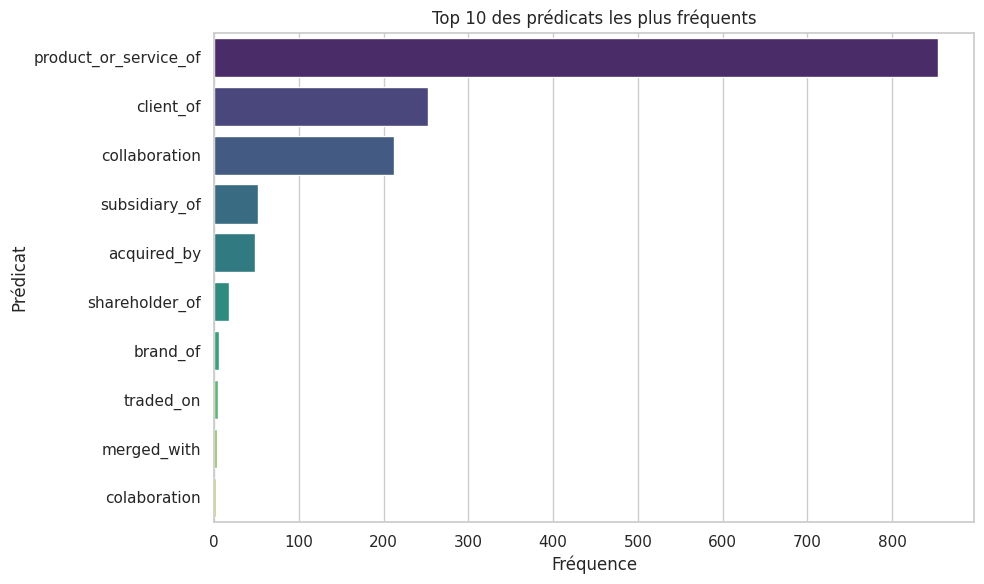

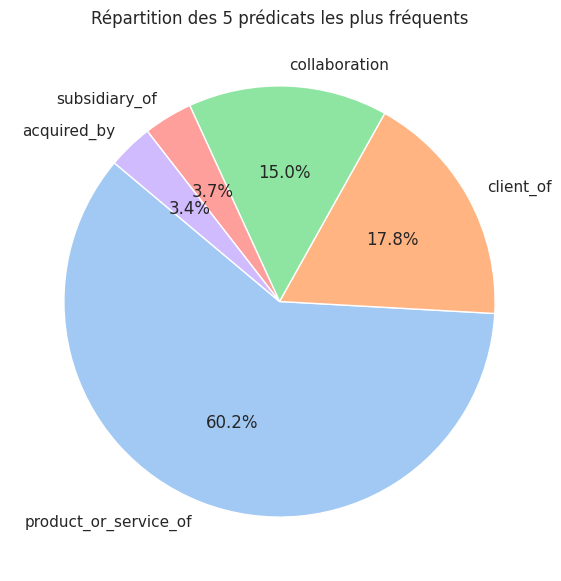

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(values), y=list(labels), palette="viridis")
plt.title("Top 10 des prédicats les plus fréquents")
plt.xlabel("Fréquence")
plt.ylabel("Prédicat")
plt.tight_layout()
plt.savefig("top10_predicats.png")
plt.show()

top5 = predicate_counts.most_common(5)
labels5, values5 = zip(*top5)

plt.figure(figsize=(7, 7))
plt.pie(values5, labels=labels5, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Répartition des 5 prédicats les plus fréquents")
plt.savefig("piechart_top5.png")
plt.show()
